**Récupération des données**

In [17]:
!wget http://perso-etis.ensea.fr/picard/UCI_Credit_Card.csv

--2018-10-17 14:25:50--  http://perso-etis.ensea.fr/picard/UCI_Credit_Card.csv
Resolving perso-etis.ensea.fr (perso-etis.ensea.fr)... 193.51.45.246
Connecting to perso-etis.ensea.fr (perso-etis.ensea.fr)|193.51.45.246|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://perso-etis.ensea.fr//picard/UCI_Credit_Card.csv [following]
--2018-10-17 14:25:50--  https://perso-etis.ensea.fr//picard/UCI_Credit_Card.csv
Connecting to perso-etis.ensea.fr (perso-etis.ensea.fr)|193.51.45.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2862995 (2.7M) [text/csv]
Saving to: ‘UCI_Credit_Card.csv.1’

UCI_Credit_Card.csv 100%[===================>]   2.73M  2.44MB/s    in 1.1s    

2018-10-17 14:25:52 (2.44 MB/s) - ‘UCI_Credit_Card.csv.1’ saved [2862995/2862995]



**Mise en forme des données**

In [0]:
import numpy as np
import pandas as pd

In [19]:
uci = pd.read_csv('UCI_Credit_Card.csv', delimiter=',')
X = uci.values[:, 1:-1]
Y = uci.values[:,-1]

size = len(Y)

perm = np.arange(size)
np.random.shuffle(perm)

X_train = X[perm[0:20000], :]
Y_train = Y[perm[0:20000]]
X_val = X[perm[20000:25000],:]
Y_val = Y[perm[20000:25000]]
X_test = X[perm[25000:], :]
Y_test = Y[perm[25000:]]

print(f'{X_train.shape} training samples, {X_val.shape} validation sampels, {X_test.shape} test samples')

(20000, 23) training samples, (5000, 23) validation sampels, (5000, 23) test samples


**Affichage des données en 2D**

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

cmap = ListedColormap(['#0000FF', '#FF0000'])

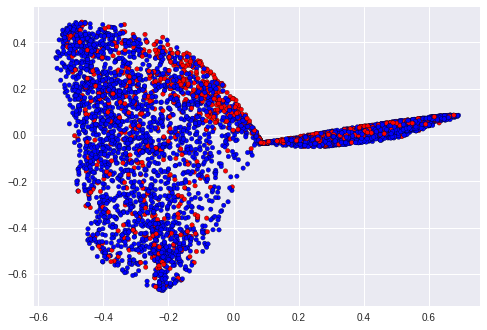

In [21]:
minmax = MinMaxScaler(feature_range=(-1,1))
X = minmax.fit_transform(X_val)

proj = KernelPCA(n_components=2, kernel='rbf', gamma=1.0)
X_pca = proj.fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1], c=Y_val, cmap=cmap, edgecolors='k', s=20)

**Standardisation des données**

In [0]:
mu = np.mean(X_train, axis=0)
si = np.std(X_train-mu, axis=0)

X_t = (X_train - mu)/si
X_v = (X_val - mu)/si

**Méthode aléatoire**

In [23]:
1-np.mean(Y_test)

0.7858

En moyenne 78.5% des personnes n'auront pas de défaut de payement ce mois-ci.

**Méthodes linéaires**

In [25]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score as a_s

clf = LDA() 
clf.fit(X_train,Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [26]:
Y_predict_val = clf.predict(X_val)
Y_predict_test = clf.predict(X_test)
print(a_s(Y_predict_val, Y_val))
print(a_s(Y_predict_test, Y_test))

0.8212
0.8186


On obtient une précision supérieure à l'aléatoire pur, qui a une précision de 78.5%, pour un temps d'exécution triplé. En standardisant les données on perd en précision.

In [27]:
clfs = LDA()
clfs.fit(X_t, Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [28]:
Y_preds = clfs.predict(X_test)
a_s(Y_preds, Y_test)

0.7858

**k-nearest neighbors**

In [29]:
from sklearn.neighbors import KNeighborsClassifier as KNC

clf = KNC(n_neighbors=30)
clf.fit(X_train,Y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

In [30]:
Y_predict_val = clf.predict(X_val)
print(a_s(Y_predict_val, Y_val))

Y_predict_test = clf.predict(X_test)
print(a_s(Y_predict_test, Y_test))

0.7816
0.7842


On obtient donc une précision a peine supérieure pour K = 30 pour des temps d'exécution presque 6 fois supérieure. On cherche par la suite le K optimal. Par ailleurs les données n'ont pas été standardisées : en effet, dans notre cas, le changement de sexe a autant d'impact que la modification de 0.01ct d'une facture. Il est donc nécessaire de standardiser les données avant d'entraîner le classifieur.

In [0]:
lst = np.linspace(10, 200, num=25, dtype=int)

In [0]:
scores_lst = []
for n in lst:
  neigh = KNC(n_neighbors=n)
  neigh.fit(X_t, Y_train)
  Y_pred2 = neigh.predict(X_v)
  scores_lst.append(a_s(Y_pred2, Y_val))

In [34]:
print(scores_lst)
index_optimal = np.argmax(scores_lst)
print("Le k optimal est " + np.str(lst[index_optimal]))

[0.812, 0.8186, 0.8154, 0.8152, 0.815, 0.8152, 0.8142, 0.814, 0.8126, 0.8124, 0.8118, 0.8114, 0.8114, 0.811, 0.81, 0.8112, 0.8106, 0.8098, 0.81, 0.8098, 0.8094, 0.8084, 0.8088, 0.8092, 0.8094]
Le k optimal est 17


In [44]:
neigh_test = KNC(n_neighbors=17)
neigh_test.fit(X_t, Y_train)
Y_pred_test = neigh_test.predict((X_test-mu)/si)
a_s(Y_pred_test, Y_test)

0.8164

**Decision trees**

In [0]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [0]:
clf = DTC(max_depth=3)
clf.fit(X_train,Y_train)
Y_predict_val = clf.predict(X_val)
scores_lst2.append(a_s(Y_predict_val, Y_val))

In [68]:
Y_predict_val = clf.predict(X_val)
print(a_s(Y_predict_val, Y_val))

Y_predict_test = clf.predict(X_test)
print(a_s(Y_predict_test, Y_test))

0.8302
0.8306


On remarque que l'apprentissage par decision tree est fortement dépendant de la profondeur maximale choisie. Une max_depth à None nous donne une précision de 71%, alors que pour max_depth = 3 on obtient la meilleure précision entre toutes les méthodes utilisées lors de ce TP : 83%.

**SVM**

In [0]:
from sklearn.svm import SVC

clf = SVC(gamma='auto')
clf.fit(X_train,Y_train)

In [48]:
Y_predict_val = clf.predict(X_val)
print(a_s(Y_predict_val, Y_val))

Y_predict_test = clf.predict(X_test)
print(a_s(Y_predict_test, Y_test))

0.7854
0.7874


**Boosting**

In [0]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

clf = GBC()
clf.fit(X_train,Y_train)

In [68]:
Y_predict_val = clf.predict(X_val)
print(a_s(Y_predict_val, Y_val))

Y_predict_test = clf.predict(X_test)
print(a_s(Y_predict_test, Y_test))

0.8198
0.8254


In [0]:
from sklearn.ensemble import AdaBoostClassifier as ABC

clf = GBC()
clf.fit(X_train,Y_train)

In [52]:
Y_predict_val = clf.predict(X_val)
print(a_s(Y_predict_val, Y_val))

Y_predict_test = clf.predict(X_test)
print(a_s(Y_predict_test, Y_test))

0.8256
0.829


On voit donc que les classifieurs entraînés avec les méthodes de boosting ont des précisions très bonnes : en effet, de toutes les méthodes testées, elle est l'une des plus précises. Néanmoins, le temps d'exécution est multiplié par 10.

**Neural networks**

In [71]:
from sklearn.neural_network import MLPClassifier as MLPC

clf = MLPC()
clf.fit(X_train,Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [72]:
Y_predict_val = clf.predict(X_val)
print(a_s(Y_predict_val, Y_val))

Y_predict_test = clf.predict(X_test)
print(a_s(Y_predict_test, Y_test))

0.7724
0.778


Le classifieur entraîné avec la méthode du réseau de neurone est une des pires méthodes pour ce problème : en effet, non seulement la précision est inférieure à la précision du classifieur aléatoire, mais aussi extrêmement variable, les valeurs pouvant changer sensiblement entre les différentes exécutions . 

**Conclusion :**

Toutes les méthodes de classification ne se valent pas : pour ce problème, les meilleurs classifieurs ont été l'entraînement avec la méthode de boosting, les decision tree (une fois que la profondeur maximale a été fixée) ainsi qu'avec les méthodes linéaires.